# Closed-loop experimentation with active learning

In order to use modAL for our response time experiment, we have to rethink modAL's workflow a little bit.

In the standard use-case of active learning we have a bunch of unlabelled samples (e.g. images) which we want to label by *experts* (e.g. telling the shown image contains either a tiger or a dog).

In the case of optimal experimental design, we don't have to collect these samples a-priori but we can determine the most promising conditions and let the participant give its label by giving us the corresponding response (observation). We are therefore able to collect new samples on the fly.

This leads us to the last part of the course, i.e. the implementation of a closed-loop experiment.

Here, we will use the automated research assistant (AutoRA) framework to set up the automated closed-loop experiment. The following image shows the general autora workflow.

![static/img/autora_workflow.png](static/img/autora_workflow.png)

(Image source: [autora](https://autoresearch.github.io/autora/))

AutoRA connects three components to enable closed-loop research, i.e. an experiment runner (executing our response time experiment), a theorist fitting a model to explain the observations (our neural network regressor), and finally an experimentalist coming up with new interesting conditions (the active learning algorithm). Further components of this framework are the integration of more services e.g. online experimentation platforms (e.g. firebase), online recruitement platforms (e.g. prolific) and database platforms. 

Fortunately, the framework was created with maximum flexibility in mind. Therefore we can integrate our components quite easily into the autora workflow.

Let's start doing that!

## Library imports

In [1]:
import sys, os

import numpy as np
import pandas as pd

# Set the path to the project folder
target_folder = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Adjust path as needed
if target_folder not in sys.path:
    sys.path.append(target_folder)
    
from resources.regressors import FFN, FFNRegressor

## Introduction to the experiment runner

The experiment runner works with independent and dependent variables. Independent variables are conditions which can be set freely. Dependent variables on the other hand are observations which depend on the previously set conditions.

We will use the random sampler to identify initial conditions.

In [2]:
# basic experiment parameters

n_units = 100

noise_level = 0.

parameters = np.random.normal(1, 0.5, (n_units, 2))
parameters = np.where(parameters < 0, 0, parameters)

Let's import the experiment runner. You can think of the experiment runner as a wrapper for our 2AFC experiment. This wrapper brings our experiment into the right format and makes it callable with only one command. 

Get familiar with this experiment runner in the next cells.

First of all we have to import it.

In [5]:
from resources.synthetic import twoafc

In [6]:
help(twoafc)

Help on function twoafc in module resources.synthetic:

twoafc(parameters: numpy.ndarray, name='2AFC', resolution=100, minimum_value_condition: float = 0.0, maximum_value_condition: float = 1.0)
    2AFC experiment with two independent variables
    
    Args:
        parameters: abstract parameters for the underlying ground truth model; must be an array of shape (n_units, 2)
        name: name of the experiment
        resolution: number of allowed values for stimulus
        Examples:
        >>> s = twoafc()
        >>> s.run(np.array([[.2,.1]]), random_state=42)
            participant id  ratio   scatteredness   response time
        0   0               1.0     1.0             1.592393



In [9]:
from autora.experiment_runner.synthetic.utilities import describe

s = twoafc(parameters)
print(describe(s))


    2AFC experiment with two independent variables

    Args:
        parameters: abstract parameters for the underlying ground truth model; must be an array of shape (n_units, 2)
        name: name of the experiment
        resolution: number of allowed values for stimulus
        Examples:
        >>> s = twoafc()
        >>> s.run(np.array([[.2,.1]]), random_state=42)
            participant id  ratio   scatteredness   response time
        0   0               1.0     1.0             1.592393
    


You can run the experiment by calling `twoafc.run` and plot the underlying ground truth with `twoafc.plotter`.

The input argument for the `run` method is the condition which is in our case `(unit_id, ratio, scatteredness)`.

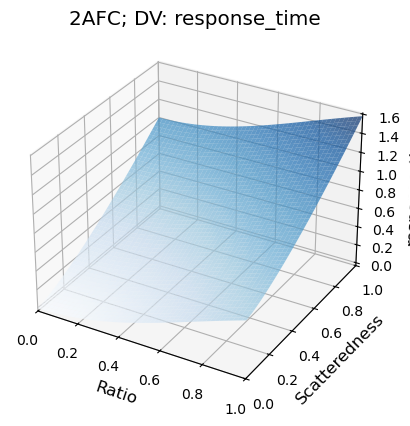

In [8]:
s.run(np.array([[0, 1, 1]]), random_state=42)
s.plotter()

## Loop contruction

When starting the construction of our loop, we first have to determine some initial conditions.

Our experimentalis in the first approach will be the `random_sampler` method, which implements a uniform sampling strategy.

You can change that later to a latin hypercube sampler and during the actual loop to an active learning strategy, of course.

In [10]:
from resources.sampler import random_sampler

# define experiment
experiment = twoafc(parameters)

# define experimentalist
experimentalist = random_sampler

# define theorist
theorist = FFNRegressor(FFN(n_units, 2), max_epochs=10, lr=0.1)

The easiest operation of an `autora`-loop is on so-called `states`. These states contain all revelant experimental information like old conditions and respective observations, the current model, all information regarding the dependent and independent variables etc.  

In [12]:
from autora.state import StandardState, on_state, estimator_on_state

# define variable names
iv_names = [iv.name for iv in experiment.variables.independent_variables]
dv_names = [dv.name for dv in experiment.variables.dependent_variables]

# define seed condition data
conditions = random_sampler(experiment.variables, sample_all=['participant_id'])

# initialize state
s = StandardState(
    variables = experiment.variables,
    conditions = conditions,
    experiment_data = pd.DataFrame(columns=iv_names+dv_names),
    models=[theorist],
)

Take a look at the state and its information to get familiar with it

In [13]:
print(s)

StandardState(variables=VariableCollection(independent_variables=[IV(name='participant_id', value_range=(0, 99), allowed_values=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), units='', type=<ValueType.REAL: 'real'>, variable_label='participant_id', rescale=1, is_covariate=False), IV(name='ratio', value_range=(0.0, 1.0), allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='ratio', rescale=1, is_covariate=False), IV(name='scatteredness', value_range=(0.0, 1.0), allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='scatteredness', rescale=1, is_covari

Now we have to wrap loop components to make them operate on the state. 

This means, instead of extracting e.g. new conditions, running the experiment on them and updating the theorist all by a extensive loop, we can just let each of the components update the state and pass the state to the next component in the loop.

In [14]:
# wrap the loop components to make them operate on the state
experiment_s = on_state(experiment.run, output=['experiment_data'])
experimentalist_s = on_state(experimentalist, output=['conditions'])
theorist_s = estimator_on_state(theorist)

Time for some automated closed-loop experimentation!

/home/daniel/repositories/CourseOptimizingExperimentalDesign/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])
/home/daniel/miniconda3/envs/oed/lib/python3.11/site-packages/autora/state.py:604: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((a, b), ignore_index=True)



epoch	train loss
1/10	0.19199891
2/10	0.05890391
3/10	0.01968319
4/10	0.01293307
5/10	0.00992959
6/10	0.00847680
7/10	0.00753656
8/10	0.00681014
9/10	0.00600977
10/10	0.00525476


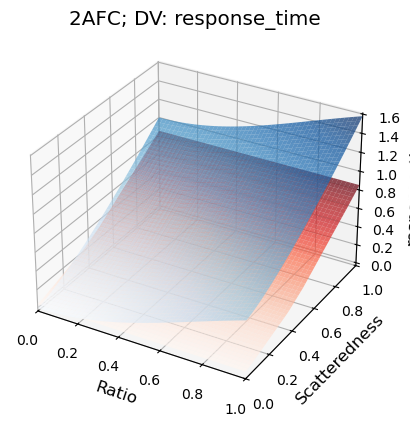

In [15]:
# start the experimentation loop
for cycle in range(1):
    s = experimentalist_s(s, num_samples=100, random_state=42+cycle, sample_all=['participant_id'])
    s = experiment_s(s, added_noise=0.0, random_state=42+cycle)
    s = theorist_s(s)
    
# plot the resulting model
experiment.plotter(s.models[0])

In your group project you will have to adjust only the experimentalist. You can take a look at the general workflow within the experimentalist by opening e.g. the `random_sampler` from above.

You don't have to adjust the other components.

If you are planning to apply an uncertainty-based sampling strategy you will have to make an ensemble of the FFNRegressor - very similar to the `modAL` tutorial. You could in fact even test some sampling strategies from the `modAL` package.

But `autora` comes also with a handful of different experimentalist implementing each another active learning strategy.

You can install them with either

`pip install -U "autora[all-experimentalists]"`

or

`pip install -U "autora[experimentalist-name]"`

You have to replace the `name` part with the experimentalist. The available experimentalists are:
- Random
- Grid
- Novelty
- Inequality
- Nearest Value
- Disagreement
- Uncertainty
- Leverage
- Falsification
- Mixture
- Prediction Filter


### Implement one of the active learning experimentalists

and see how they work. You can familiarize yourself with them in the official documentation.

## Congratulations!

You have done all tutorials in the **Optimizing Experimental Design Course**! Now you can start thinking about your group project :)